# Определение прибыльного тарифа сотовой связи

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018-й год. Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
* Сообщение — 3 рубля.
* 1 Гб интернет-трафика — 200 рублей.
  
**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* Минута разговора — 1 рубль;
* Сообщение — 1 рубль;
* 1 Гб интернет-трафика: 150 рублей.

**План.**
1. [Загрузка данных и изучение общей информации.](#section_id_1)
2. [Подготовка данных.](#section_id_2)
* 2.1. Привести данные к нужным типам.
* 2.2. Найти и исправить ошибки, если они есть.
* 2.3. Посчитать количество сделанных звонков для каждого пользователя по месяцам.
* 2.4. Посчитать количество израсходованных минут разговора для каждого пользователя по месяцам.
* 2.5. Посчитать количество отправленных сообщений для каждого пользователя по месяцам.
* 2.6. Посчитать количество потраченных мегабайт для каждого пользователя по месяцам.
3. [Анализ данных и подсчёт выручки.](#section_id_2)
* 3.1.  Объединить все посчитанные выше значения в новый датафрейм. Посчитать поместную выручку с каждого пользователя.
* 3.2. Сохнанить статистические метрики для каждой пары месяц-тариф
в одной таблице (среднее значение, стандартное отклонение, медиана).
* 3.3. Построить распределения количества звонков, продолжительности звонков, количества сообщений и потраченного графика по месяцам с разрезе тарифов. Сделать выводы.
4. [Проверка гипотез.](#section_id_4)
* 4.1 Средняя выручка с пользователей тарифов "Ультра" и "Смарт" различаются.
* 4.2 Средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.
5. [Общий вывод.](#section_id_5)

**Описание данных**

**Таблица users — информация о пользователях:** 
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, значит, тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tarif` — название тарифного плана

**Таблица calls — информация о звонках:**
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица messages — информация о сообщениях:**
* `id` — уникальный номер звонка
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица internet — информация об интернет-сессиях:**
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

**Таблица tariffs — информация о тарифах:**
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## 1. Загрузка данных и изучение общей информации.<a id='section_id_1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

* Файл `calls.csv`

In [2]:
calls = pd.read_csv('calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Выведем гистограмму для столбца с продолжительностью звонков.

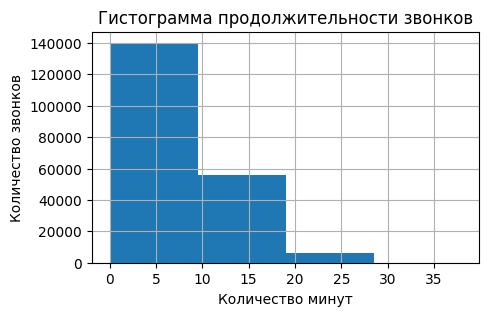

In [4]:
plt.figure(figsize=(5, 3))
calls['duration'].hist(bins=4)
plt.title('Гистограмма продолжительности звонков')
plt.xlabel('Количество минут')
plt.ylabel('Количество звонков')
plt.show();

Больше всего звонков приходится на небольшую продолжительность, до 10 минут.

* Файл `internet.csv`

In [5]:
sessions = pd.read_csv('internet.csv')
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Выведем гистограмму для столбца с количеством потраченных мегабайт.

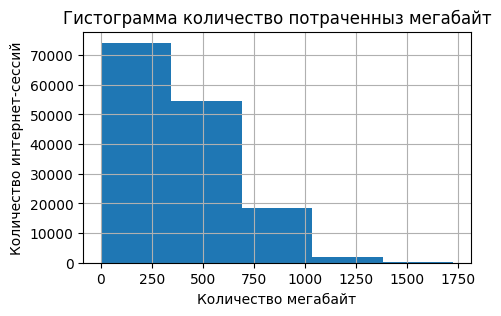

In [7]:
plt.figure(figsize=(5, 3))
sessions['mb_used'].hist(bins=5)
plt.title('Гистограмма количество потраченныз мегабайт')
plt.xlabel('Количество мегабайт')
plt.ylabel('Количество интернет-сессий')
plt.show();

Чаще всего у клиентов на трафик уходит до 500 мегабайт.

* Файл `messages.csv`

In [8]:
messages = pd.read_csv('messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


* Файл `tariffs.csv`

In [10]:
tariffs = pd.read_csv('tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


* Файл `users.csv`

In [12]:
users = pd.read_csv('users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


## 2. Подготовка данных.<a id='section_id_2'></a>

### 2.1. Приведение данных к нужным типам.

Приведём столбцы

- `reg_date` из таблицы `users`
- `churn_date` из таблицы `users`
- `call_date` из таблицы `calls`
- `message_date` из таблицы `messages`
- `session_date` из таблицы `sessions`

к новому типу с помощью метода `to_datetime()`.

In [14]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

calls['call_date'] = pd.to_datetime(calls['call_date'])

messages['message_date'] = pd.to_datetime(messages['message_date'])
sessions['session_date'] = pd.to_datetime(sessions['session_date'])

### 2.2. Найдём и исправим ошибки, если они есть.

* В данных есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Однако в столбце `duration` датафрейма `calls` значения дробные. Округлим значения столбца `duration` вверх с помощью метода `numpy.ceil()` и приведём столбец `duration` к типу `int`.

In [15]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int')

* Удалим столбец `Unnamed: 0` из датафрейма `sessions`. Столбец с таким названием возникает, когда данные сохраняют с указанием индекса (`df.to_csv(..., index=column)`). Он сейчас не понадобится.

In [16]:
sessions = sessions.drop('Unnamed: 0', axis=1)

### 2.3. Посчитаем количество сделанных звонков для каждого пользователя по месяцам.

* Создадим столбец `month` в датафрейме `calls` с номером месяца из столбца `call_date`.

In [17]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

* Создадим столбец `month` в датафрейме `messages` с номером месяца из столбца `message_date`.

In [18]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

* СоздаLBV столбец `month` в датафрейме `sessions` с номером месяца из столбца `session_date`.

In [19]:
sessions['month'] = pd.DatetimeIndex(sessions['session_date']).month

* Посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам.

In [20]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))
calls_per_month.head(30)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33
        11        32
        12        33
1003    8         55
        9        134
        10       108
        11       115
        12       108
1004    5          9
        6         31
        7         22
        8         19
        9         26
        10        29
        11        19
        12        21

### 2.4. Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам.

In [21]:
minutes_per_month = calls.groupby(['user_id','month']).agg(minutes=('duration', 'sum'))
minutes_per_month.head(30)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212
        11         243
        12         236
1003    8          380
        9          961
        10         855
        11         824
        12         802
1004    5           35
        6          171
        7          135
        8          137
        9          117
        10         145
        11         117
        12         130

### 2.5. Посчитаем количество отправленных сообщений для каждого пользователя по месяцам.

In [22]:
messages_per_month = messages.groupby(['user_id','month']).agg(messages=('message_date', 'count'))
messages_per_month.head(30)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12
1003    8            37
        9            91
        10           83
        11           94
        12           75
1004    5            95
        6           134
        7           181
        8           151
        9           146
        10          165
        11          158
        12          162
1005    1             7
        2            38

### 2.6. Посчитаем количество потраченных мегабайт для каждого пользователя по месяцам.

In [23]:
sessions_per_month = sessions.groupby(['user_id','month']).agg({'mb_used': 'sum'})
sessions_per_month.head(30)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25
        11     18587.28
        12     18113.73
1003    8       8565.21
        9      12468.87
        10     14768.14
        11     11356.89
        12     10121.53
1004    5      13403.98
        6      17600.02
        7      22229.58
        8      28584.37
        9      15109.03
        10     18475.44
        11     15616.02
        12     18021.04

## 3. Анализ данных и подсчёт выручки.<a id='section_id_3'></a>

## 3.1. Объединим все посчитанные значения в новый датафрейм. Посчитать помесячную выручку с каждого пользователя.

* Определим сколько процентов клиентов прекратили пользоваться тарифом.

In [24]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

Расторгли договор 7.6% клиентов из датасета

* Объединим все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [25]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


* Проверим пропуски в таблице `user_behavior` после объединения.

In [26]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Заполним образовавшиеся пропуски в данных:

In [27]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

* Присоединим информацию о тарифах

In [28]:
tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)
user_behavior = user_behavior.merge(tariffs, on='tariff')

* Посчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф

In [29]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

* Переведём превышающие тариф мегабайты в гигабайты и сохраним в столбец `paid_gb`

In [30]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

* Посчитаем выручку за минуты разговора, сообщения и интернет.

In [31]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

* Посчитаем помесячную выручку с каждого пользователя, она будет храниться в столбец `total_cost`

In [32]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

### 3.2. Сохнаним статистические метрики для каждой пары месяц-тариф в одной таблице (среднее значение, стандартное отклонение, медиана).

* Созданим датафрейм `stats_df` для каждой пары "месяц-тариф". Он будет хранить основные характеристики статистических метрик (среднее значение, стандартное отклонение, медиана).

In [33]:
stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
8,5,smart,55.24,15805.18,33.77,387.36,25.38,5978.23,27.04,186.60,59.0,16323.94,30.0,433.0
9,5,ultra,72.51,19363.15,37.85,510.33,41.08,10046.11,40.31,289.60,75.0,18696.43,25.0,519.0


### 3.3. Построим распределения количества звонков, продолжительности звонков, количества сообщений и потраченного графика по месяцам с разрезе тарифов. Сделать выводы.

* Распределение среднего количества звонков по видам тарифов и месяцам.

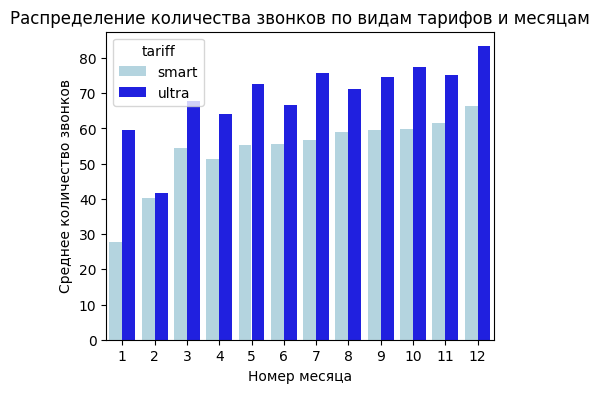

In [34]:
plt.figure(figsize=(5, 4))
ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

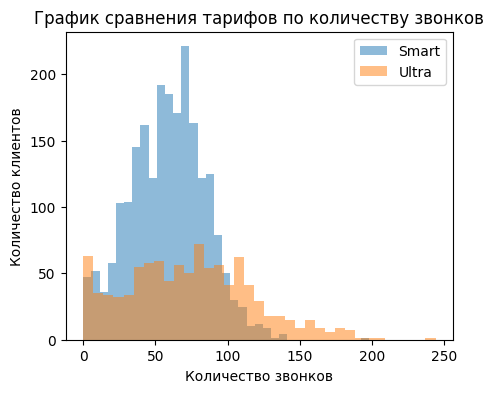

In [35]:
plt.figure(figsize=(5, 4))
user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.title('График сравнения тарифов по количеству звонков')
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

Среднее количество звонков растёт у обоих тарифов в течение года. Тариф Ultra превышает тариф Smart по частоте звонков клиентами.

* Распределение средней продолжительности звонков по видам тарифов и месяцам.

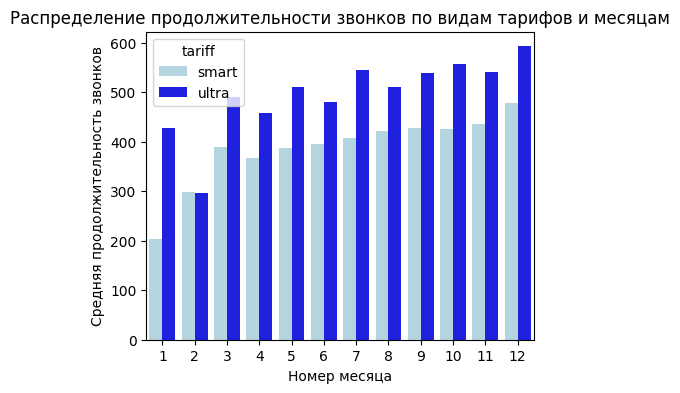

In [36]:
plt.figure(figsize=(5, 4))
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

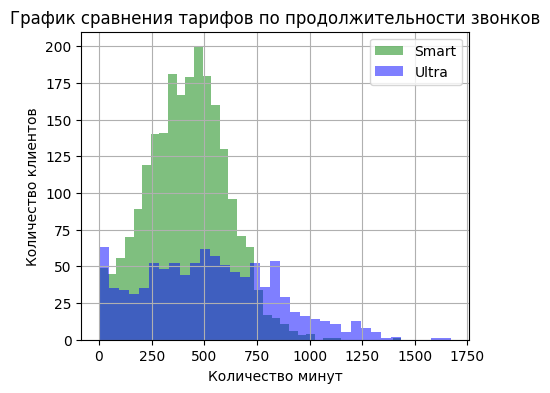

In [37]:
plt.figure(figsize=(5, 4))
user_behavior[user_behavior['tariff'] =='smart']['minutes'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['minutes'].hist(bins=35, alpha=0.5, color='blue')
plt.legend(['Smart', 'Ultra'])
plt.title('График сравнения тарифов по продолжительности звонков')
plt.xlabel('Количество минут')
plt.ylabel('Количество клиентов')
plt.show()

**Вывод.** Длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

* Распределение среднего количества сообщений по видам тарифов и месяцам

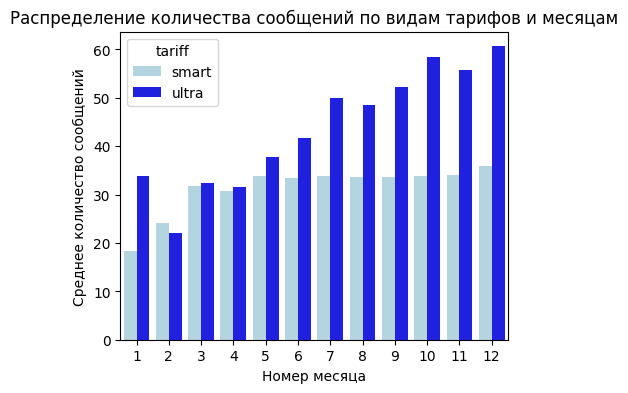

In [38]:
plt.figure(figsize=(5, 4))
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

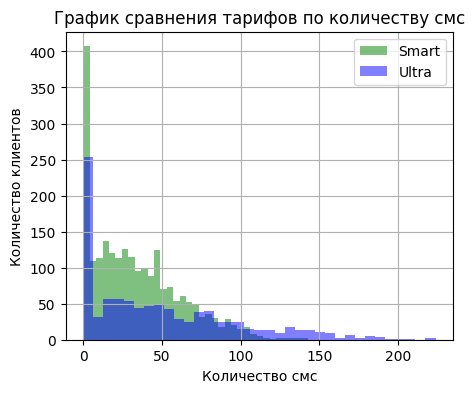

In [39]:
plt.figure(figsize=(5, 4))
user_behavior[user_behavior['tariff'] =='smart']['messages'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['messages'].hist(bins=35, alpha=0.5, color='blue')
plt.legend(['Smart', 'Ultra'])
plt.title('График сравнения тарифов по количеству смс')
plt.xlabel('Количество смс')
plt.ylabel('Количество клиентов')
plt.show()

**Вывод.** В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.

* Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам

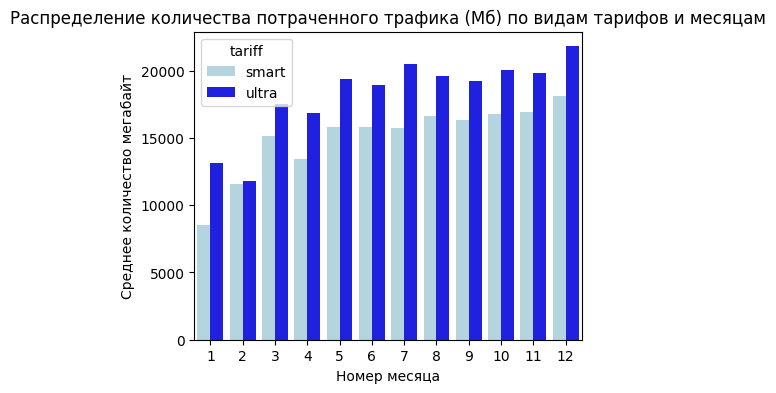

In [40]:
plt.figure(figsize=(5, 4))
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Сравнение потраченных мегабайт среди пользователей тарифов Smart и Ultra

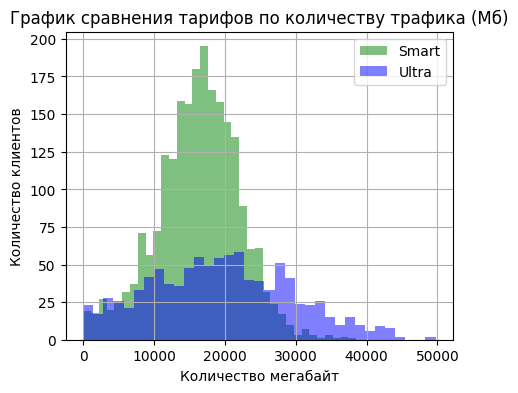

In [41]:
plt.figure(figsize=(5, 4))
user_behavior[user_behavior['tariff'] =='smart']['mb_used'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['mb_used'].hist(bins=35, alpha=0.5, color='blue')
plt.legend(['Smart', 'Ultra'])
plt.title('График сравнения тарифов по количеству трафика (Мб)')
plt.xlabel('Количество мегабайт')
plt.ylabel('Количество клиентов')
plt.show()

**Вывод.** Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.

## 4. Проверка гипотез.<a id='section_id_4'></a>

### 4.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

H<sub>0</sub>: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"`

H<sub>a</sub>: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"`
alpha = 0.05

In [42]:
total_cost_1 = user_behavior.loc[user_behavior['tariff'] == 'smart']['total_cost']
total_cost_2 = user_behavior.loc[user_behavior['tariff'] == 'ultra']['total_cost']
results = st.ttest_ind(
    total_cost_1, 
    total_cost_2, equal_var = False)

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250
Отвергаем нулевую гипотезу


Наши данные показывают очень маловероятные результаты, поэтому они могут не противоречить альтернативной гипотезе H<sub>1</sub>.

### 4.2.Средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.

H<sub>0</sub>: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы

H<sub>а</sub>: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы


In [43]:
total_cost_1 = user_behavior.loc[user_behavior['city'] == 'Москва']['total_cost']
total_cost_2 = user_behavior.loc[user_behavior['city'] != 'Москва']['total_cost']
results = st.ttest_ind(
    total_cost_1, 
    total_cost_2, equal_var = False)

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Наш эксперимент говорит нам о том, что наши данные не противоречат нулевой гипотезе.

## 5. Общий вывод.<a id='section_id_5'></a>

**Количество звонков.**

Пользователи тарифа Ultra совершают больше количество звонков, чем пользователи тарифа Smart. В разбивке по месяцам можно наблюдать что пользователи обоих тарифов в течение года нелинейно увеличивают количество звонков.

**Средняя продолжительность звонков.**

Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

**Среднее количество сообщений.**

В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.

**Использование интернет-трафика.**

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.

**Проверка статиститческих гипотез.**

* Наши данные ге противоречат гипотезе о том, что выручка пользователей Ультра ра равна выручке пользователей Смарт.
* Наши данные ге противоречат гипотезе о том, выручка пользователей Москвы равна выручке пользователей не из Москвы.